# 1. Install MarkLLM

In [4]:
!pip install -r requirements.txt

download_models = False

opt_path = "models/opt-1.3b"
llama_path = "models/llama-7b"
nllb_path = "models/nllb-200-distilled-600M"
bert_large_uncased_path = "models/compositional-bert-large-uncased/"
t5_path = "models/t5-v1_1-xxl"
starcoder_path = "models/starcoder"

if download_models:
    !pip install -U huggingface_hub
    !export HF_ENDPOINT=https://hf-mirror.com
    HUGGINGFACE_TOKEN = "" 
    !huggingface-cli login --token $HUGGINGFACE_TOKEN
    !huggingface-cli download --resume-download facebook/opt-1.3b --local-dir {opt_path}
    !huggingface-cli download --resume-download princeton-nlp/Sheared-LLaMA-1.3B --local-dir {llama_path}
    !huggingface-cli download --resume-download facebook/nllb-200-distilled-600M --local-dir {nllb_path}
    !huggingface-cli download --resume-download google-bert/bert-large-uncased --local-dir {bert_large_uncased_path}
    !huggingface-cli download --resume-download google/t5-v1_1-xxl --local-dir {t5_path}
    !huggingface-cli download --resume-download bigcode/starcoder --local-dir {starcoder_path}

# 2. Watermaring Algorithm Invocation

In [5]:
import torch
import json
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load data
with open('dataset/c4/processed_c4.json', 'r') as f:
    lines = f.readlines()
item = json.loads(lines[0])
prompt = item['prompt']
natural_text = item['natural_text']


def test_algorithm(algorithm_name):
    # Check algorithm name
    assert algorithm_name in ['KGW', 'Unigram', 'SWEET', 'EWD', 'SIR', 'XSIR', 'UPV', 'EXP', 'EXPEdit']

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Transformers config
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                                            tokenizer=AutoTokenizer.from_pretrained(opt_path),
                                            vocab_size=50272,
                                            device=device,
                                            max_new_tokens=200,
                                            min_length=230,
                                            do_sample=True,
                                            no_repeat_ngram_size=4)

    # Load watermark algorithm
    myWatermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    # Generate text
    watermarked_text = myWatermark.generate_watermarked_text(prompt)
    unwatermarked_text = myWatermark.generate_unwatermarked_text(prompt)

    # Detect
    detect_result1 = myWatermark.detect_watermark(watermarked_text)
    detect_result2 = myWatermark.detect_watermark(unwatermarked_text)
    detect_result3 = myWatermark.detect_watermark(natural_text)

    print("LLM-generated watermarked text:")
    print(watermarked_text)
    print('\n')
    print(detect_result1)
    print('\n')

    print("LLM-generated unwatermarked text:")
    print(unwatermarked_text)
    print('\n')
    print(detect_result2)
    print('\n')

    print("Natural text:")
    print(natural_text)
    print('\n')
    print(detect_result3)

In [6]:
test_algorithm('KGW')

LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems, according to the company. The server features a 32 Megabit Ethernet LAN (throughout the server, the LAN is capable of handling multiple Ethernet connections, according to IBM). The server has an available storage area network (SAN) capable of managing 40 Gigabytes per second (GB/s) or greater, according to IMD SGI, an imaging vendor for Linux. The virtual machine image is based on the Linux V4.6, an updated version of the Linux operating system. The software is available now at no extra charge on a license basis. The system also is able to run HyperText Transfer Protocol/Extent-3 (HTTP/XML), Microsoft Corp.'s Internet Information Services and WINDOWS operating systems, the company said. The system will ship without the hardware operating system. Only the server's storage components will ship with t

In [7]:
test_algorithm('Unigram')

LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems. The server software runs on Opteron processors and supports the Open Virtual Machine (OVM) software for virtualizing Linux on top of the operating systems to run on cluster servers and storage nodes. The storage software can run on Opterons and virtualizes on top of storage nodes and features support for the Linux-on- steroids (Loose Linux) software for running virtual servers directly on Linux nodes and the Open Directory (OD) software for supporting both file and block level shared storage for using IBM i servers and database nodes in Loose Linux-based networks. The Open Directory software can run both on Linux and on OS-level virtual machines.

For use in Loose Directory networks, IBM provides IBM i storage controller drivers that support the use of NetBIOS to manage IBM mSeries and other IBM i 

In [8]:
test_algorithm('SWEET')

LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems. The cluster also contains several clusters running the IBM System Verilog HDL (the HDL is for optimizing software, in particular CPU designs, designs for optimizing network systems, or for optimizing hardware-to-application systems). Based on the system's characteristics and workload, the clusters are interconnected to form a managed system that is capable of handling a vast range of business applications and supporting eDiscovery. A typical managed system may have 64 to 128 processors and two to four storage devices for high-performance analytics. Other managed systems support a much more modest enterprise-class workload (e.g, 100 processors) and utilize four storage devices. The underlying hardware used to form the managed system may vary from application to application and the hardware may also 

In [9]:
test_algorithm('UPV')

LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems.

This week's Linux Foundation's Fusion Developer Conference has attracted thousands of people in Chicago, including Intel chief operating officer Paul Otellini, Microsoft senior vice president of Windows server technologies Greg Smith, IBM director of Enterprise Server Technologies Dave Miller, and more.

One of the main topics is the latest Linux kernel 5.2, a change that IBM's Opternon-based servers will get early access to, although IBM and Microsoft have not specified which ones of its Opteron line of servers will get Linux 5.2. They will run it during the Fusion Developer Conference.

Otellini, Smith, Miller and AMD senior manager of Linux, virtualisation, and cloud services Pat Cipoletti all talked extensively about Linux, although they did not get any chance to actually use Linux for develop

In [10]:
test_algorithm('EWD')

LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems. Customers can choose a combination of the servers to run their Linux applications or Windows-based applications using the Linux Enterprise Server, which IBM's software runs on those servers. (Credit: IBM)

By providing free enterprise applications that meet global business demands, Linux Enterprise Server consolidates the Linux-based OS and operating system, the Linux software toolset, the Linux clustering software and the Linux systems management (eBusiness) operating system into a single platform capable of delivering true enterprise-wide availability at high price points. The Linux Enterprise Server and the hardware are co-located with a Linux-based software that is easy to use. Customers can be assured of an effective response and quick response times when the Linux eServer 325 servers are in r

In [11]:
test_algorithm('SIR')

Some weights of BertModel were not initialized from the model checkpoint at watermark/sir/model/compositional-bert-large-uncased/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.380 seconds.
Prefix dict has been built successfully.


LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems.

"Our agreement with IBM will enable us to offer solutions to our clients and partners in more remote locations," Mr Healy said.

The eServer 325 has been an early development workhorse but has been more generally used to support customers who wanted to manage and analyse large computing loads. And IBM has suggested some will grow to include more applications and processing, which could be seen as more suited to cloud computing models.

IBM said more information would be available in coming weeks on how organisations could access its cloud management software and its software for virtualising or transforming hardware. That software has been used to manage and deliver cloud computing with more conventional hardware virtualisation.

Mr Healy suggested he was interested in taking advantage of opportun

In [12]:
test_algorithm('XSIR')

LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems as well as open-source virtualization technology such as VMware and virtualX on top of it. The Opteron is a top-performing server for storage virtualization and management with a price-performance ratio that can be just as good as an Intel Xeon processor. The software can be installed and maintained on a range of data center hardware.

IBM is also moving forward with a range of new storage components. CloudXtreme storage allows customers to quickly deploy storage solutions and has a variety of expansion and upgrade options, including a virtual disk array that runs like a conventional storage array with no upfront cost and that can run as an Amazon EBS volume.

In addition, Cloud-based technology that runs Linux and Windows can be leveraged on CloudXtrememt for cloud-managed virtual machines. Cloud-b

In [13]:
test_algorithm('EXP')

LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems. Lexmark finds itself in a unique position -- many of its systems run under agreement with HP and IBM. It has shops that can run its LPAR and injection technology but also manage systems that have been configured as LabVIEW systems. I met with Dorion Gibson, who is the VP of Strategy and International Marketing at Lexmark, to discuss the blending of HP and IBM components.

David McCaffrey: Let's talk about LPAR and injection technology. What are they used for?

Dorian Gibson: LPAR allows us to have a software solution inside a PLC that allows higher throughput. We can run larger APIs for analytical systems and that sort of thing. So that's what we call injection technology because we can adapt to any application data, through the technology that's been integrated with Analysis Services.

You can run

# 3. Mechanism Visualization

In [14]:
import torch
import gc
import json
from visualize.font_settings import FontSettings
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
from visualize.page_layout_settings import PageLayoutSettings
from visualize.data_for_visualization import DataForVisualization
from visualize.visualizer import DiscreteVisualizer, ContinuousVisualizer
from visualize.legend_settings import DiscreteLegendSettings, ContinuousLegendSettings
from visualize.color_scheme import ColorSchemeForDiscreteVisualization, ColorSchemeForContinuousVisualization
from IPython.display import display
from PIL import Image, ImageOps, ImageFont, ImageDraw

def test_discreet_visualization():
    tokens = ["PREFIX", "PREFIX", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test"]
    flags = [-1, -1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
    weights = [0, 0, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4]

    discreet_visualizer = DiscreteVisualizer(color_scheme=ColorSchemeForDiscreteVisualization(),
                                            font_settings=FontSettings(),
                                            page_layout_settings=PageLayoutSettings(),
                                            legend_settings=DiscreteLegendSettings())
    img = discreet_visualizer.visualize(data=DataForVisualization(tokens, flags, weights),
                                     show_text=True, visualize_weight=True, display_legend=True)

    img.save("test1.png")
    display(img)


def test_continuous_visualization():
    tokens = ["PREFIX", "PREFIX", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test"]
    values = [None, None, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4]
    weights = [0, 0, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4]

    continuous_visualizer = ContinuousVisualizer(color_scheme=ColorSchemeForContinuousVisualization(),
                                                    font_settings=FontSettings(),
                                                    page_layout_settings=PageLayoutSettings(),
                                                    legend_settings=ContinuousLegendSettings())
    img = continuous_visualizer.visualize(data=DataForVisualization(tokens, values, weights),
                                        show_text=False, visualize_weight=False, display_legend=True)

    img.save("test2.png")
    display(img)


def get_data(algorithm_name):
    # Load data
    with open('dataset/c4/processed_c4.json', 'r') as f:
        lines = f.readlines()
    item = json.loads(lines[0])
    prompt = item['prompt']

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Transformers config
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                                            tokenizer=AutoTokenizer.from_pretrained(opt_path),
                                            vocab_size=50272,
                                            device=device,
                                            max_new_tokens=200,
                                            min_length=230,
                                            no_repeat_ngram_size=4)

    myWatermark = AutoWatermark.load(f'{algorithm_name}',
                                     algorithm_config=f'config/{algorithm_name}.json',
                                     transformers_config=transformers_config)

    watermarked_text = myWatermark.generate_watermarked_text(prompt)
    unwatermarked_text = myWatermark.generate_unwatermarked_text(prompt)
    watermarked_data = myWatermark.get_data_for_visualization(watermarked_text)
    unwatermarked_data = myWatermark.get_data_for_visualization(unwatermarked_text)

    return watermarked_data, unwatermarked_data


def test_visualization_without_weight(algorithm_name, visualize_type='discrete'):
    # Validate input
    assert visualize_type in ['discrete', 'continuous']
    if visualize_type == 'discrete':
        assert algorithm_name in ['KGW', 'Unigram', 'SWEET', 'UPV', 'SIR', 'XSIR', 'EWD']
    else:
        assert algorithm_name in ['EXP', 'EXPEdit']

    # Get data for visualization
    watermarked_data, unwatermarked_data = get_data(algorithm_name)

    # Init visualizer
    if visualize_type == 'discrete':
        visualizer = DiscreteVisualizer(color_scheme=ColorSchemeForDiscreteVisualization(),
                                        font_settings=FontSettings(),
                                        page_layout_settings=PageLayoutSettings(),
                                        legend_settings=DiscreteLegendSettings())
    else:
        visualizer = ContinuousVisualizer(color_scheme=ColorSchemeForContinuousVisualization(),
                                        font_settings=FontSettings(),
                                        page_layout_settings=PageLayoutSettings(),
                                        legend_settings=ContinuousLegendSettings())

    # Visualize
    watermarked_img = visualizer.visualize(data=watermarked_data,
                                           show_text=True,
                                           visualize_weight=True,
                                           display_legend=True)

    unwatermarked_img = visualizer.visualize(data=unwatermarked_data,
                                             show_text=True,
                                             visualize_weight=True,
                                             display_legend=True)

    watermarked_img.save(f"{algorithm_name}_watermarked.png")
    unwatermarked_img.save(f"{algorithm_name}_unwatermarked.png")

    watermarked_width, watermarked_height = watermarked_img.size
    unwatermarked_width, unwatermarked_height = unwatermarked_img.size

    font_size = 22
    font = ImageFont.truetype("./font/times.ttf", font_size)
    title_height = 80

    new_watermarked_img = Image.new('RGB', (watermarked_width, watermarked_height + title_height), (255, 255, 255))
    new_unwatermarked_img = Image.new('RGB', (unwatermarked_width, watermarked_height + title_height), (255, 255, 255))

    draw1 = ImageDraw.Draw(new_watermarked_img)
    text_bbox1 = draw1.textbbox((0, 0), f"{algorithm_name} watermarked", font=font)
    draw1.text((int((watermarked_width - text_bbox1[2] - text_bbox1[0]) * 0.3), int(title_height * 0.35)), f"{algorithm_name} watermarked", fill=(0, 0, 0), font=font)

    draw2 = ImageDraw.Draw(new_unwatermarked_img)
    text_bbox2 = draw2.textbbox((0, 0), f"{algorithm_name} unwatermarked", font=font)
    draw2.text((int((unwatermarked_width - text_bbox2[2] - text_bbox2[0]) * 0.3), int(title_height * 0.35)), f"{algorithm_name} unwatermarked", fill=(0, 0, 0), font=font)

    new_watermarked_img.paste(watermarked_img, (0, title_height))
    new_unwatermarked_img.paste(unwatermarked_img, (0, title_height))

    total_width = watermarked_width + unwatermarked_width
    max_height = watermarked_height + title_height

    new_img = Image.new('RGB', (total_width, max_height))

    new_img.paste(new_watermarked_img, (0, 0))
    new_img.paste(new_unwatermarked_img, (watermarked_width, 0))
    display(new_img)

def test_visualization_with_weight(algorithm_name):
    # Validate input
    assert algorithm_name in ['SWEET', 'EWD']

    # Get data for visualization
    watermarked_data, unwatermarked_data = get_data(algorithm_name)

    # Init visualizer
    visualizer = DiscreteVisualizer(color_scheme=ColorSchemeForDiscreteVisualization(),
                                    font_settings=FontSettings(),
                                    page_layout_settings=PageLayoutSettings(),
                                    legend_settings=DiscreteLegendSettings())

    # Visualize
    watermarked_img = visualizer.visualize(data=watermarked_data,
                                           show_text=True,
                                           visualize_weight=True,
                                           display_legend=True)

    unwatermarked_img = visualizer.visualize(data=unwatermarked_data,
                                             show_text=True,
                                             visualize_weight=True,
                                             display_legend=True)

    watermarked_img.save(f"{algorithm_name}_watermarked.png")
    unwatermarked_img.save(f"{algorithm_name}_unwatermarked.png")

    watermarked_width, watermarked_height = watermarked_img.size
    unwatermarked_width, unwatermarked_height = unwatermarked_img.size

    font_size = 22
    font = ImageFont.truetype("./font/times.ttf", font_size)
    title_height = 80

    new_watermarked_img = Image.new('RGB', (watermarked_width, watermarked_height + title_height), (255, 255, 255))
    new_unwatermarked_img = Image.new('RGB', (unwatermarked_width, watermarked_height + title_height), (255, 255, 255))

    draw1 = ImageDraw.Draw(new_watermarked_img)
    text_bbox1 = draw1.textbbox((0, 0), f"{algorithm_name} watermarked", font=font)
    draw1.text((int((watermarked_width - text_bbox1[2] - text_bbox1[0]) * 0.3), int(title_height * 0.35)), f"{algorithm_name} watermarked", fill=(0, 0, 0), font=font)

    draw2 = ImageDraw.Draw(new_unwatermarked_img)
    text_bbox2 = draw2.textbbox((0, 0), f"{algorithm_name} unwatermarked", font=font)
    draw2.text((int((unwatermarked_width - text_bbox2[2] - text_bbox2[0]) * 0.3), int(title_height * 0.35)), f"{algorithm_name} unwatermarked", fill=(0, 0, 0), font=font)

    new_watermarked_img.paste(watermarked_img, (0, title_height))
    new_unwatermarked_img.paste(unwatermarked_img, (0, title_height))

    total_width = watermarked_width + unwatermarked_width
    max_height = watermarked_height + title_height

    new_img = Image.new('RGB', (total_width, max_height))

    new_img.paste(new_watermarked_img, (0, 0))
    new_img.paste(new_unwatermarked_img, (watermarked_width, 0))
    display(new_img)

## 3.1 Warm Up: Test Visualizer Using Provided Text

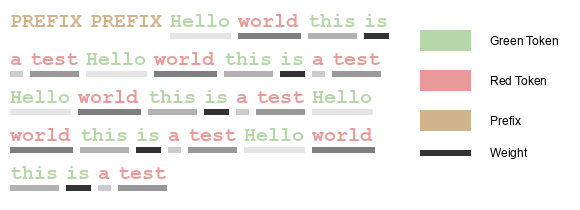

In [15]:
test_discreet_visualization()

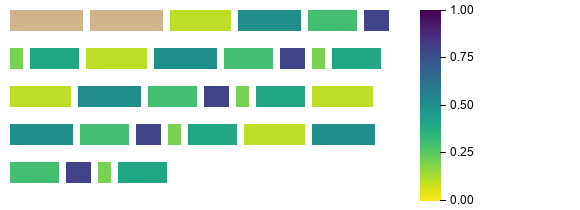

In [16]:
test_continuous_visualization()

## 3.2 Mechansim Visualization of Watermarking Algorithms

### 3.2.1 KGW Family

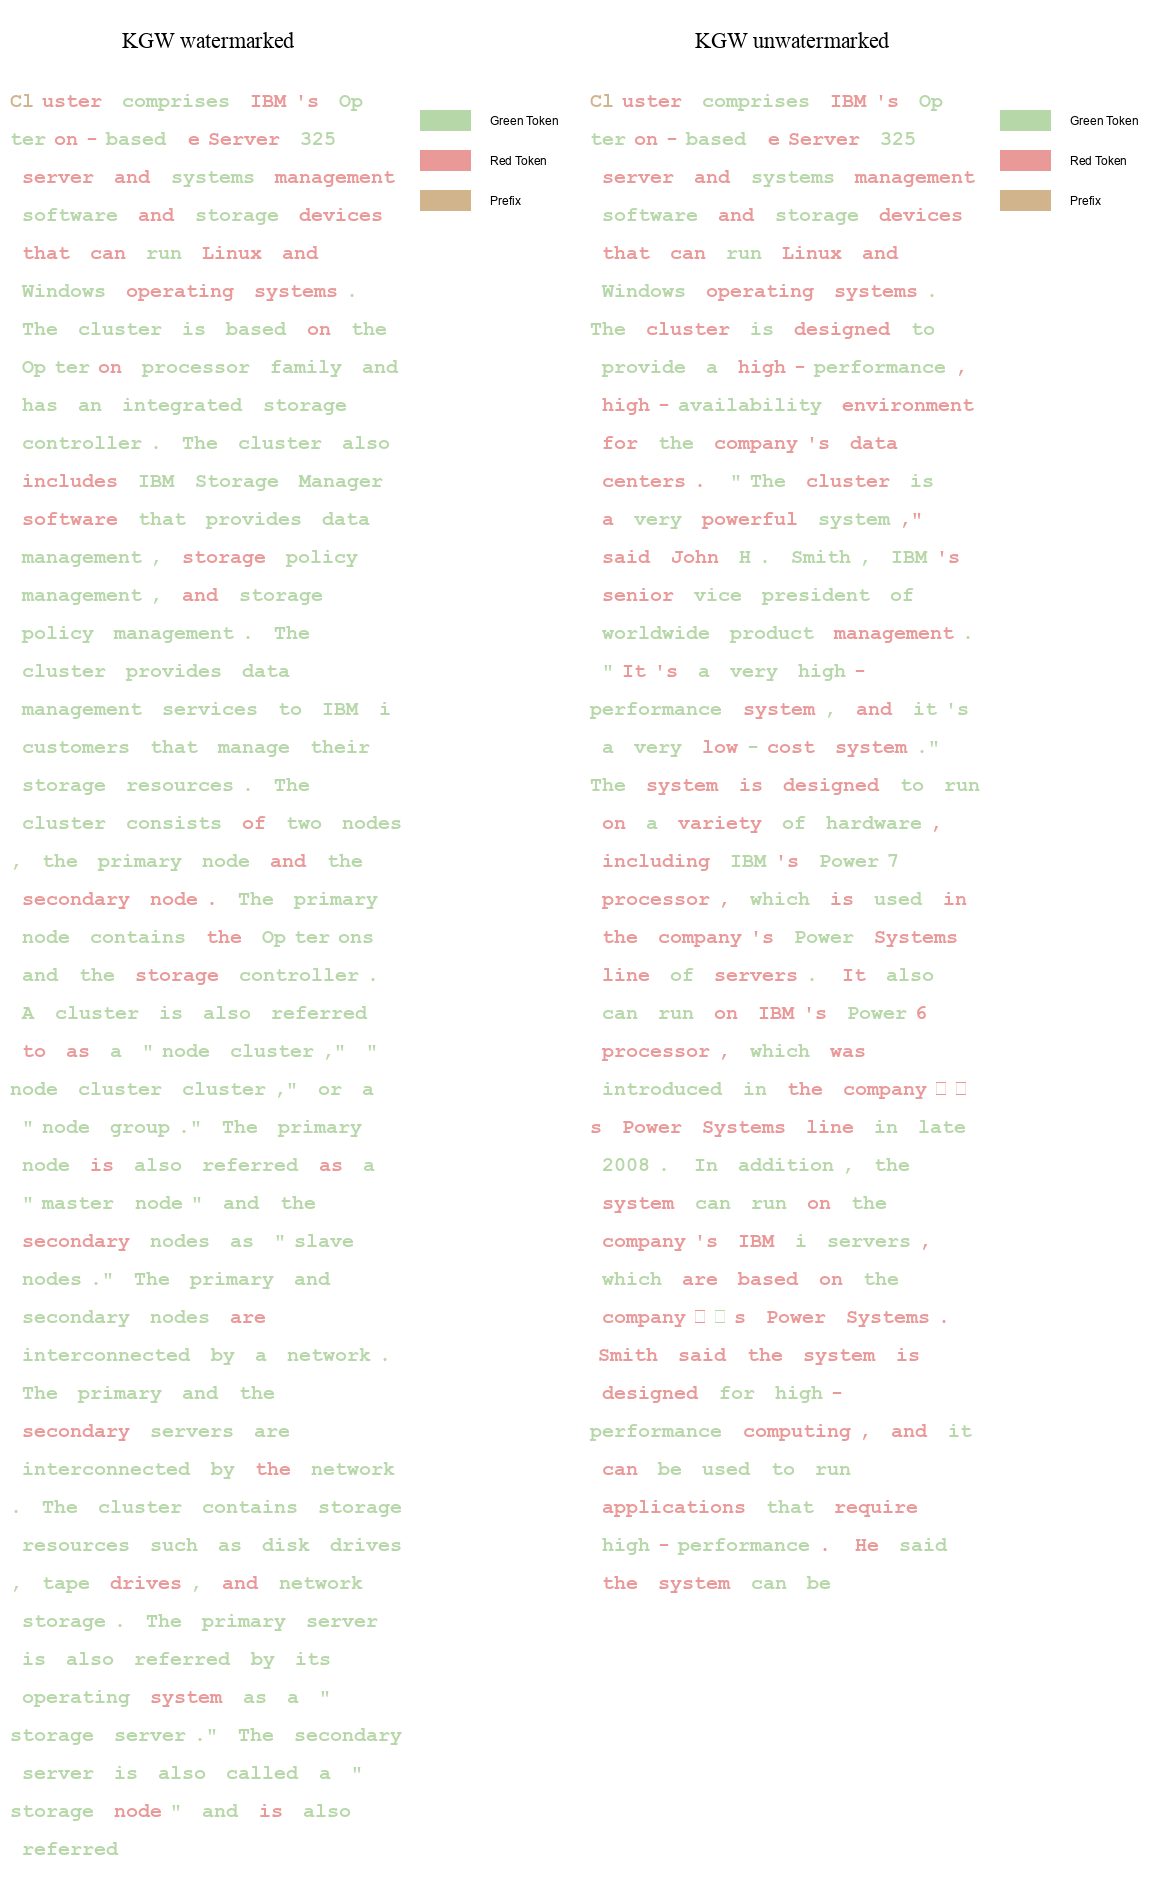

In [17]:
test_visualization_without_weight('KGW', 'discrete')

### 3.2.2 Christ Family

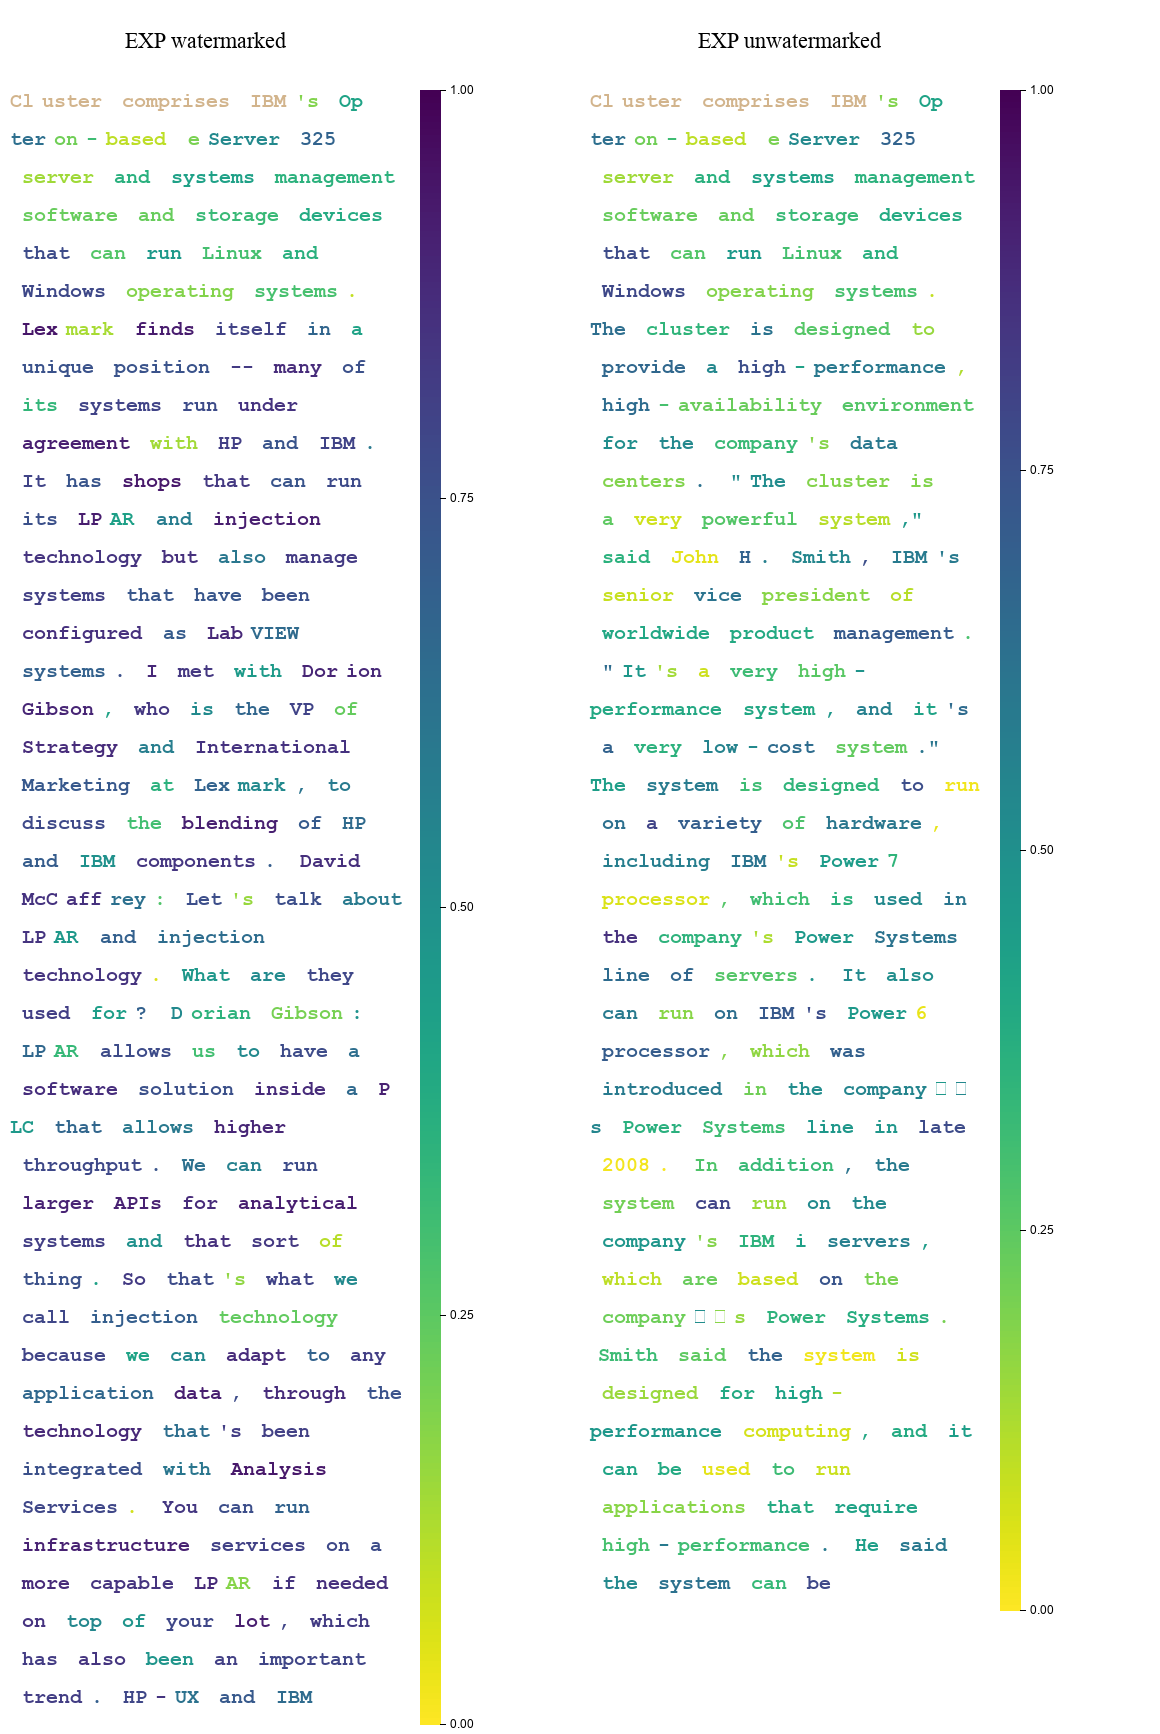

In [18]:
test_visualization_without_weight('EXP', 'continuous')

### 3.2.3 Handling Weighted Token Difference in Visualization

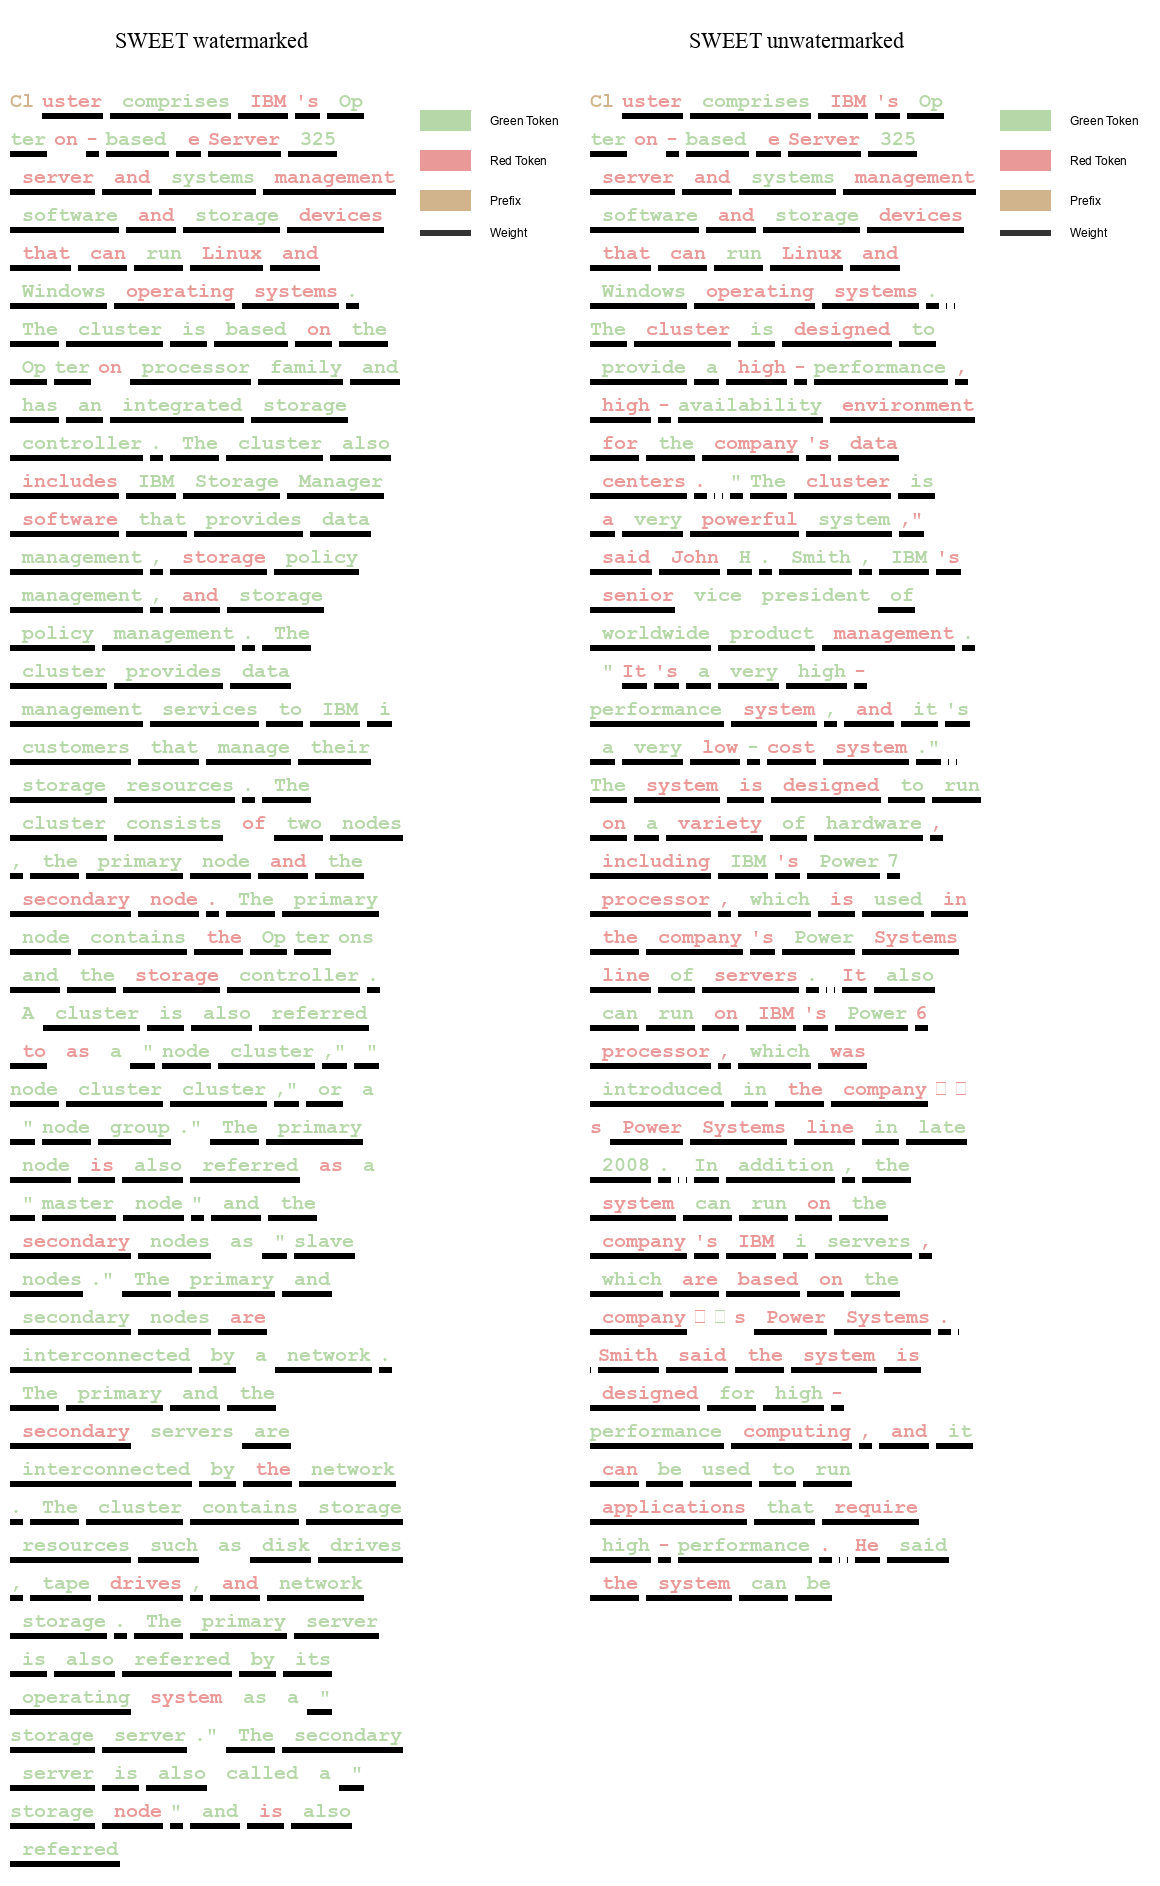

In [19]:
test_visualization_with_weight('SWEET')

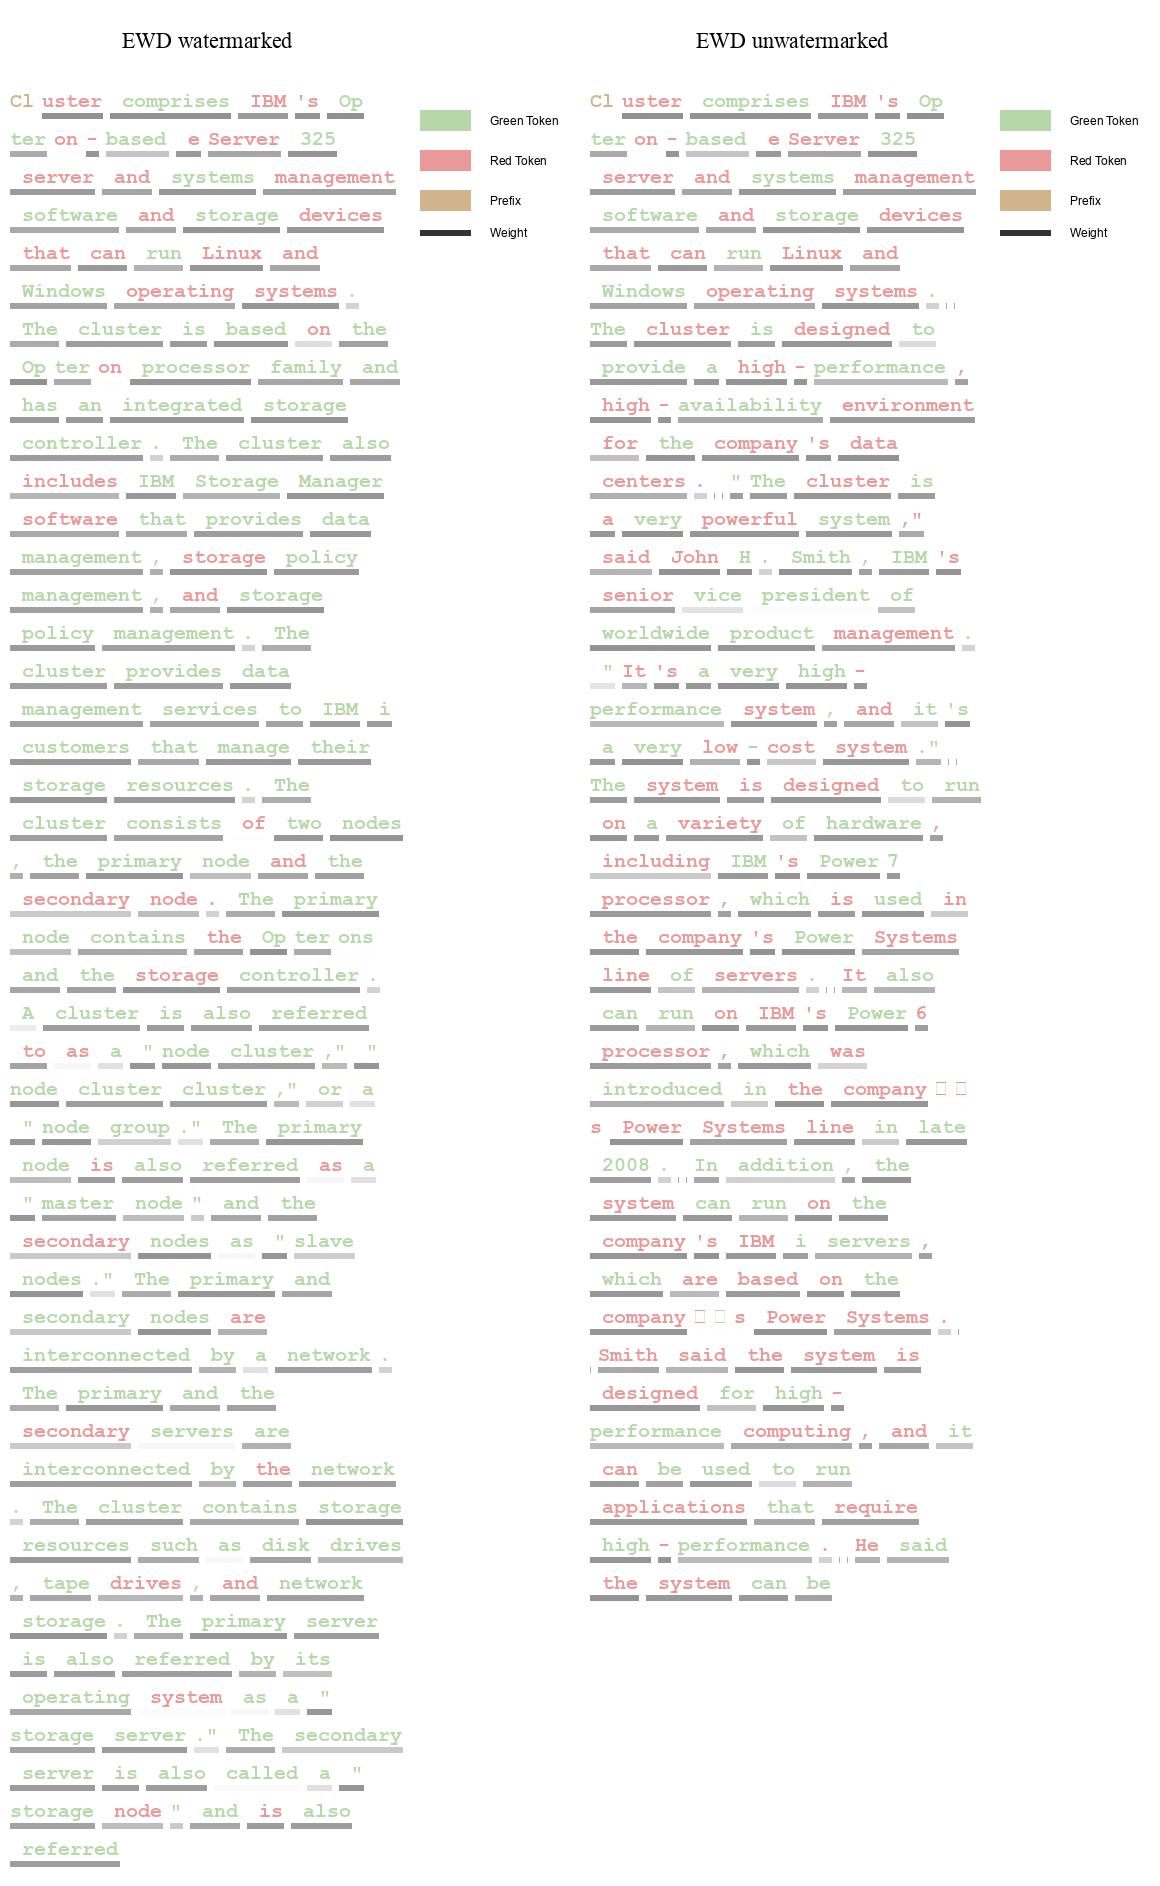

In [20]:
test_visualization_with_weight('EWD')

# 4. Automated Comprehensive Evaluation

## 4.1 Watermark Detection Pipeline

In [21]:
import torch
import json
from evaluation.dataset import C4Dataset
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from evaluation.tools.success_rate_calculator import DynamicThresholdSuccessRateCalculator
from transformers import AutoModelForCausalLM, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration, BertTokenizer, BertForMaskedLM
from evaluation.pipelines.detection import WatermarkedTextDetectionPipeline, UnWatermarkedTextDetectionPipeline, DetectionPipelineReturnType
from evaluation.tools.text_editor import TruncatePromptTextEditor, TruncateTaskTextEditor, WordDeletion, SynonymSubstitution, ContextAwareSynonymSubstitution, GPTParaphraser, DipperParaphraser

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
  gc.collect()
  torch.cuda.empty_cache()
  with torch.no_grad():
      torch.cuda.empty_cache()

def test_detection_pipeline(algorithm_name, attack_name):
    my_dataset = C4Dataset('dataset/c4/processed_c4.json')
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                                             tokenizer=AutoTokenizer.from_pretrained(opt_path),
                                             vocab_size=50272,
                                             device=device,
                                             max_new_tokens=200,
                                             min_length=230,
                                             do_sample=True,
                                             no_repeat_ngram_size=4)

    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    if attack_name == 'Word-D':
      attack = WordDeletion(ratio=0.3)
    elif attack_name == 'Word-S':
      attack = SynonymSubstitution(ratio=0.5)
    elif attack_name == 'Word-S(Context)':
      attack = ContextAwareSynonymSubstitution(ratio=0.5,
                                               tokenizer=BertTokenizer.from_pretrained('/data2/shared_model/bert-large-uncased'),
                                               model=BertForMaskedLM.from_pretrained('/data2/shared_model/bert-large-uncased').to(device))
    elif attack_name == 'Doc-P(GPT-3.5)':
        attack = GPTParaphraser(openai_model='gpt-3.5-turbo',
                                prompt='Please rewrite the following text: ')
    elif attack_name == 'Doc-P(Dipper)':
        attack = DipperParaphraser(tokenizer=T5Tokenizer.from_pretrained('/data2/shared_model/google/t5-v1_1-xxl/'),
                                   model=T5ForConditionalGeneration.from_pretrained('/data2/shared_model/kalpeshk2011/dipper-paraphraser-xxl/', device_map='auto'),
                                   lex_diversity=60, order_diversity=0, sent_interval=1,
                                   max_new_tokens=100, do_sample=True, top_p=0.75, top_k=None)


    pipline1 = WatermarkedTextDetectionPipeline(dataset=my_dataset, text_editor_list=[TruncatePromptTextEditor(), attack],
                                                show_progress=True, return_type=DetectionPipelineReturnType.SCORES)

    pipline2 = UnWatermarkedTextDetectionPipeline(dataset=my_dataset, text_editor_list=[TruncatePromptTextEditor()],
                                            show_progress=True, return_type=DetectionPipelineReturnType.SCORES)

    calculator = DynamicThresholdSuccessRateCalculator(labels=['TPR', 'F1'], rule='best')
    print(calculator.calculate(pipline1.evaluate(my_watermark), pipline2.evaluate(my_watermark)))



In [22]:
test_detection_pipeline('KGW', 'Word-D')

Processing: 100%|█████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.00it/s]

{'TPR': 0.995, 'F1': 0.9974937343358395}


## 4.2 Text Quality Analysis Pipeline

In [23]:
import torch
import json
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from evaluation.dataset import C4Dataset, WMT16DE_ENDataset, HumanEvalDataset
from evaluation.tools.success_rate_calculator import DynamicThresholdSuccessRateCalculator
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer, LlamaTokenizer
from evaluation.tools.text_editor import TruncatePromptTextEditor, TruncateTaskTextEditor ,CodeGenerationTextEditor
from evaluation.tools.text_quality_analyzer import PPLCalculator, LogDiversityAnalyzer, BLEUCalculator, PassOrNotJudger, GPTTextDiscriminator
from evaluation.pipelines.detection import WatermarkedTextDetectionPipeline, UnWatermarkedTextDetectionPipeline, DetectionPipelineReturnType
from evaluation.pipelines.quality_analysis import (DirectTextQualityAnalysisPipeline, ReferencedTextQualityAnalysisPipeline, ExternalDiscriminatorTextQualityAnalysisPipeline,
                                                   QualityPipelineReturnType)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
  gc.collect()
  torch.cuda.empty_cache()
  with torch.no_grad():
      torch.cuda.empty_cache()

def test_direct_quality_analysis_pipeline(algorithm_name, quality_analyzer_name):
    my_dataset = C4Dataset('dataset/c4/processed_c4.json')
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                          tokenizer=AutoTokenizer.from_pretrained(opt_path),
                          vocab_size=50272,
                          device=device,
                          max_new_tokens=200,
                          min_length=230,
                          do_sample=True,
                          no_repeat_ngram_size=4)
    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    if quality_analyzer_name == 'PPL':
      analyzer = PPLCalculator(model=AutoModelForCausalLM.from_pretrained(llama_path, device_map='auto'),
                                tokenizer=LlamaTokenizer.from_pretrained(llama_path),
                                device=device)
    elif quality_analyzer_name == 'Log Diversity':
      analyzer = LogDiversityAnalyzer()

    quality_pipeline = DirectTextQualityAnalysisPipeline(dataset=my_dataset,
                                watermarked_text_editor_list=[TruncatePromptTextEditor()],
                                unwatermarked_text_editor_list=[],
                                analyzer=analyzer,
                                unwatermarked_text_source='natural', show_progress=True,
                                return_type=QualityPipelineReturnType.MEAN_SCORES)

    print(f"{quality_analyzer_name}:")
    print(quality_pipeline.evaluate(my_watermark))


def test_referenced_quality_analysis_pipeline_1(algorithm_name):
    """Evaluate the impact on text quality in the machine translation task."""
    my_dataset = WMT16DE_ENDataset('dataset/wmt16_de_en/validation.jsonl')
    tokenizer= AutoTokenizer.from_pretrained(nllb_path, src_lang="deu_Latn")
    transformers_config = TransformersConfig(model=AutoModelForSeq2SeqLM.from_pretrained(nllb_path).to(device),
                                                tokenizer=tokenizer,
                                                device=device,
                                                forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"])

    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    quality_pipeline = ReferencedTextQualityAnalysisPipeline(dataset=my_dataset,
                                                              watermarked_text_editor_list=[],
                                                              unwatermarked_text_editor_list=[],
                                                              analyzer=BLEUCalculator(),
                                                              unwatermarked_text_source='generated', show_progress=True,
                                                              return_type=QualityPipelineReturnType.MEAN_SCORES)


    print("BLEU:")
    print(quality_pipeline.evaluate(my_watermark))


def test_referenced_quality_analysis_pipeline_2(algorithm_name):
    """Evaluate the impact on text quality in the code generation task."""
    my_dataset = HumanEvalDataset('dataset/human_eval/test.jsonl')
    tokenizer= AutoTokenizer.from_pretrained(tiny_starcoder_path)
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(tiny_starcoder_path, device_map='auto'),
                                             tokenizer=tokenizer,
                                             device=device,
                                             min_length=200,
                                             max_length=400)

    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    quality_pipeline = ReferencedTextQualityAnalysisPipeline(dataset=my_dataset,
                                  watermarked_text_editor_list=[TruncateTaskTextEditor(),CodeGenerationTextEditor()],
                                  unwatermarked_text_editor_list=[TruncateTaskTextEditor(), CodeGenerationTextEditor()],
                                  analyzer=PassOrNotJudger(),
                                  unwatermarked_text_source='generated', show_progress=True,
                                  return_type=QualityPipelineReturnType.MEAN_SCORES)

    print("pass@1:")
    print(quality_pipeline.evaluate(my_watermark))


def test_discriminator_quality_analysis_pipeline(algorithm_name):
    my_dataset = WMT16DE_ENDataset('dataset/wmt16_de_en/validation.jsonl')
    tokenizer= AutoTokenizer.from_pretrained(nllb_path, src_lang="deu_Latn")
    transformers_config = TransformersConfig(model=AutoModelForSeq2SeqLM.from_pretrained(nllb_path).to(device),
                                                tokenizer=tokenizer,
                                                device=device,
                                                forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"])

    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    quality_pipeline = ExternalDiscriminatorTextQualityAnalysisPipeline(dataset=my_dataset,
                                      watermarked_text_editor_list=[],
                                      unwatermarked_text_editor_list=[],
                                      analyzer=GPTTextDiscriminator(openai_model='gpt-4',
                                      task_description='Translate the following German text to English'),
                                      unwatermarked_text_source='generated', show_progress=True,
                                      return_type=QualityPipelineReturnType.MEAN_SCORES
                                      )

    print("Win Rate:")
    print(quality_pipeline.evaluate(my_watermark))

In [ ]:
test_direct_quality_analysis_pipeline('KGW', 'PPL')

In [ ]:
test_direct_quality_analysis_pipeline('Unigram', 'Log Diversity')

In [ ]:
test_referenced_quality_analysis_pipeline_1('SIR')

In [ ]:
test_referenced_quality_analysis_pipeline_2('SWEET')

In [ ]:
import openai

openai.api_key = ""

test_discriminator_quality_analysis_pipeline('EWD')